In [1]:
import os
import numpy as np
import pyedflib
from scipy.stats import zscore
from scipy.signal import stft
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ⚙️ 설정
root_dir = "/home/mhb0917/캡스톤디자인/sleep/recordings"
seq_len = 10
batch_size = 16
epochs = 50
learning_rate = 0.001

label_map = {
    'Sleep stage W': 0,
    'Sleep stage N1': 1,
    'Sleep stage N2': 1,
    'Sleep stage N3': 2,
    'Sleep stage R': 3
}

In [2]:
# 1️⃣ 데이터 로드
def load_ecg_and_labels(sn_id, root_dir):
    base = f"SN{int(sn_id):03d}"
    ecg_path = os.path.join(root_dir, f"{base}.edf")
    label_path = os.path.join(root_dir, f"{base}_sleepscoring.edf")
    if not os.path.exists(ecg_path) or not os.path.exists(label_path):
        print(f"❌ 파일 없음: {base}")
        return [], []

    with pyedflib.EdfReader(ecg_path) as ecg_reader:
        ecg_signal = ecg_reader.readSignal(7)

    with pyedflib.EdfReader(label_path) as label_reader:
        onsets, durations, labels = label_reader.readAnnotations()

    segments, segment_labels = [], []
    for onset, duration, label in zip(onsets, durations, labels):
        label_str = label.decode() if isinstance(label, bytes) else label
        if label_str not in label_map:
            continue
        start = int(onset * 256)
        num_segments = int(duration // 30)
        for i in range(num_segments):
            seg_start = start + i * 7680
            seg_end = seg_start + 7680
            if seg_end > len(ecg_signal):
                break
            segment = zscore(ecg_signal[seg_start:seg_end])
            if np.isnan(segment).any():
                continue
            segments.append(segment.astype(np.float32))
            segment_labels.append(label_map[label_str])
    return segments, segment_labels

In [3]:
# 2️⃣ STFT 함수
def compute_stft(segment, fs=256, nperseg=256, noverlap=128):
    f, t, Zxx = stft(segment, fs=fs, nperseg=nperseg, noverlap=noverlap)
    # 로그 스케일 변환
    magnitude = 10 * np.log10(np.abs(Zxx) + 1e-8)
    return magnitude.T  # (time, freq)


In [4]:
# 3️⃣ STFT + 시퀀스 생성
def create_sequences_stft(segments, labels, seq_len=10):
    X, y = [], []
    for i in range(len(segments) - seq_len + 1):
        stft_seqs = []
        for seg in segments[i:i+seq_len]:
            stft_feat = compute_stft(seg)  # (time, freq)
            stft_seqs.append(stft_feat)  # (time, freq)
        X.append(np.stack(stft_seqs))  # (seq_len, time, freq)
        y.append(labels[i + seq_len - 1])
    return np.array(X), np.array(y)

def merge_data(data_dict):
    X_all, y_all = [], []
    for X, y in data_dict.values():
        if len(X) == 0:
            continue
        X_all.append(X)
        y_all.append(y)
    if len(X_all) == 0:
        return np.array([]), np.array([])
    return np.concatenate(X_all), np.concatenate(y_all)


In [5]:
# 4️⃣ Dataset
class SleepDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
# 5️⃣ 모델 정의
class CNN_STFT_LSTM(nn.Module):
    def __init__(self, time_bins, freq_bins, cnn_out=64, lstm_hidden=128, num_classes=4):
        super(CNN_STFT_LSTM, self).__init__()
        
        # 1️⃣ CNN Feature Extractor (3단계 CNN)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, cnn_out, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(cnn_out),
            nn.ReLU(),
            
            nn.AdaptiveAvgPool2d((1, 1))  # (batch*seq, channels, 1, 1)
        )
        
        # 2️⃣ LSTM for Sequence Modeling
        self.lstm = nn.LSTM(
            input_size=cnn_out,
            hidden_size=lstm_hidden,
            num_layers=2,
            batch_first=True
        )
        
        # 3️⃣ Fully Connected Output Layer
        self.fc = nn.Linear(lstm_hidden, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len, time_bins, freq_bins)
        batch_size, seq_len, time_bins, freq_bins = x.shape
        
        # CNN 입력을 위해 채널 차원 추가 (1 채널)
        x = x.view(batch_size * seq_len, 1, time_bins, freq_bins)  # (batch*seq, 1, time, freq)
        
        # CNN 처리
        x = self.cnn(x)  # (batch*seq, cnn_out, 1, 1)
        x = x.view(batch_size, seq_len, -1)  # (batch, seq_len, cnn_out)
        
        # LSTM 처리
        out, _ = self.lstm(x)  # (batch, seq_len, lstm_hidden)
        
        # 마지막 시퀀스의 출력만 사용
        out = out[:, -1, :]  # (batch, lstm_hidden)
        
        # 최종 분류
        return self.fc(out)


In [7]:
# 4️⃣ 학습 및 평가 함수
def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, device='cuda'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Train
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y_batch).sum().item()
            total += y_batch.size(0)
        avg_train_loss = total_loss / len(train_loader)
        train_acc = correct / total if total > 0 else 0
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

def evaluate_model(model, loader, device='cuda'):
    model = model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    print(classification_report(all_labels, all_preds, labels=[0,1,2,3], target_names=["W", "N1/2", "N3", "R"], zero_division=0))
    cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2,3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["W", "N1/2", "N3", "R"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


In [8]:
# 5️⃣ 데이터 처리 및 학습
train_X, train_y = [], []
val_data, test_data = {}, {}

for i in range(1, 155):
    segments, labels = load_ecg_and_labels(i, root_dir)
    if segments is not None and len(segments) > 0:
        X_seq, y_seq = create_sequences_stft(segments, labels, seq_len)
        if len(X_seq) == 0:
            continue
        if 1 <= i <= 93:
            train_X.append(X_seq)
            train_y.append(y_seq)
        elif 94 <= i <= 123:
            val_data[f"SN{i:03d}"] = (X_seq, y_seq)
        else:
            test_data[f"SN{i:03d}"] = (X_seq, y_seq)

train_X = np.concatenate(train_X)
train_y = np.concatenate(train_y)

val_X, val_y = [], []
for X, y in val_data.values():
    val_X.append(X)
    val_y.append(y)
val_X = np.concatenate(val_X)
val_y = np.concatenate(val_y)

time_bins, freq_bins = train_X.shape[2], train_X.shape[3]
print(f"✅ Train shape: {train_X.shape}, time={time_bins}, freq={freq_bins}")

❌ 파일 없음: SN014


❌ 파일 없음: SN064


❌ 파일 없음: SN135


✅ Train shape: (81795, 10, 61, 129), time=61, freq=129


In [9]:
train_loader = DataLoader(SleepDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(SleepDataset(val_X, val_y), batch_size=batch_size, shuffle=False)

model = CNN_STFT_LSTM(time_bins, freq_bins)

train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=epochs, lr=learning_rate, device='cuda')


Epoch [1/50] Train Loss: 1.0845 Acc: 0.5263 | Val Loss: 1.1103


Epoch [2/50] Train Loss: 0.9783 Acc: 0.5638 | Val Loss: 1.1146


Epoch [3/50] Train Loss: 0.9105 Acc: 0.5963 | Val Loss: 1.2342


Epoch [4/50] Train Loss: 0.8525 Acc: 0.6272 | Val Loss: 1.2374


Epoch [5/50] Train Loss: 0.7994 Acc: 0.6534 | Val Loss: 1.2257


Epoch [6/50] Train Loss: 0.7523 Acc: 0.6745 | Val Loss: 1.2365


Epoch [7/50] Train Loss: 0.7089 Acc: 0.6955 | Val Loss: 1.2802


Epoch [8/50] Train Loss: 0.6698 Acc: 0.7137 | Val Loss: 1.4207


Epoch [9/50] Train Loss: 0.6343 Acc: 0.7319 | Val Loss: 1.4065


Epoch [10/50] Train Loss: 0.5957 Acc: 0.7496 | Val Loss: 1.5436


Epoch [11/50] Train Loss: 0.5639 Acc: 0.7649 | Val Loss: 1.4265


Epoch [12/50] Train Loss: 0.5333 Acc: 0.7802 | Val Loss: 1.6352


Epoch [13/50] Train Loss: 0.5061 Acc: 0.7910 | Val Loss: 1.6391


Epoch [14/50] Train Loss: 0.4793 Acc: 0.8010 | Val Loss: 1.6206


Epoch [15/50] Train Loss: 0.4508 Acc: 0.8156 | Val Loss: 1.6321


Epoch [16/50] Train Loss: 0.4268 Acc: 0.8267 | Val Loss: 1.7643


Epoch [17/50] Train Loss: 0.4081 Acc: 0.8355 | Val Loss: 1.8409


Epoch [18/50] Train Loss: 0.3883 Acc: 0.8439 | Val Loss: 1.9090


Epoch [19/50] Train Loss: 0.3670 Acc: 0.8528 | Val Loss: 1.9183


Epoch [20/50] Train Loss: 0.3476 Acc: 0.8621 | Val Loss: 1.9389


Epoch [21/50] Train Loss: 0.3319 Acc: 0.8680 | Val Loss: 1.9105


Epoch [22/50] Train Loss: 0.3152 Acc: 0.8750 | Val Loss: 2.1570


Epoch [23/50] Train Loss: 0.2979 Acc: 0.8812 | Val Loss: 2.1007


Epoch [24/50] Train Loss: 0.2880 Acc: 0.8869 | Val Loss: 2.1989


Epoch [25/50] Train Loss: 0.2741 Acc: 0.8925 | Val Loss: 2.1405


Epoch [26/50] Train Loss: 0.2617 Acc: 0.8988 | Val Loss: 2.4536


Epoch [27/50] Train Loss: 0.2502 Acc: 0.9032 | Val Loss: 2.2801


Epoch [28/50] Train Loss: 0.2391 Acc: 0.9075 | Val Loss: 2.4045


Epoch [29/50] Train Loss: 0.2351 Acc: 0.9085 | Val Loss: 2.4603


Epoch [30/50] Train Loss: 0.2222 Acc: 0.9141 | Val Loss: 2.4299


Epoch [31/50] Train Loss: 0.2139 Acc: 0.9178 | Val Loss: 2.7844


Epoch [32/50] Train Loss: 0.2074 Acc: 0.9197 | Val Loss: 2.4111


Epoch [33/50] Train Loss: 0.1993 Acc: 0.9233 | Val Loss: 2.5350


Epoch [34/50] Train Loss: 0.1892 Acc: 0.9268 | Val Loss: 2.5611


Epoch [35/50] Train Loss: 0.1871 Acc: 0.9282 | Val Loss: 2.7143


Epoch [36/50] Train Loss: 0.1775 Acc: 0.9321 | Val Loss: 2.8686


Epoch [37/50] Train Loss: 0.1728 Acc: 0.9348 | Val Loss: 3.0775


Epoch [38/50] Train Loss: 0.1704 Acc: 0.9351 | Val Loss: 2.8583


Epoch [39/50] Train Loss: 0.1631 Acc: 0.9383 | Val Loss: 2.7788


Epoch [40/50] Train Loss: 0.1628 Acc: 0.9384 | Val Loss: 2.9076


Epoch [41/50] Train Loss: 0.1554 Acc: 0.9408 | Val Loss: 2.9854


Epoch [42/50] Train Loss: 0.1530 Acc: 0.9417 | Val Loss: 2.8666


Epoch [43/50] Train Loss: 0.1474 Acc: 0.9439 | Val Loss: 2.9753


Epoch [44/50] Train Loss: 0.1483 Acc: 0.9434 | Val Loss: 2.9379


Epoch [45/50] Train Loss: 0.1404 Acc: 0.9470 | Val Loss: 2.9310


Epoch [46/50] Train Loss: 0.1350 Acc: 0.9484 | Val Loss: 3.0570


Epoch [47/50] Train Loss: 0.1332 Acc: 0.9498 | Val Loss: 2.9362


Epoch [48/50] Train Loss: 0.1336 Acc: 0.9507 | Val Loss: 3.0749


Epoch [49/50] Train Loss: 0.1284 Acc: 0.9516 | Val Loss: 3.0344


Epoch [50/50] Train Loss: 0.1267 Acc: 0.9525 | Val Loss: 3.1432


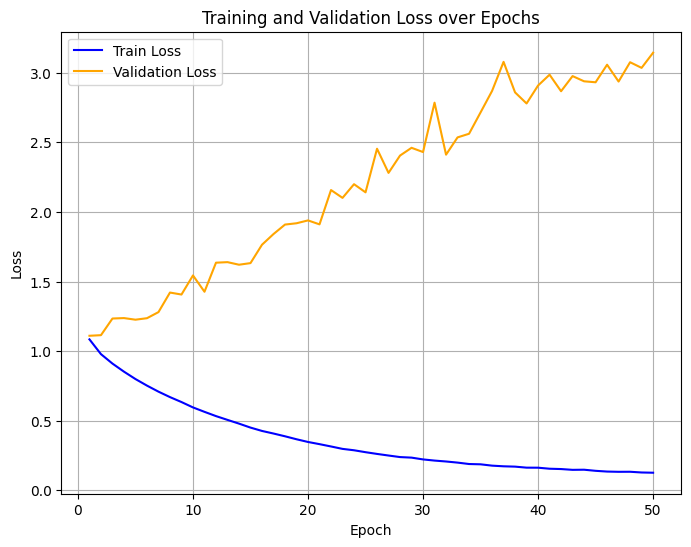

In [10]:
# Loss 그래프 출력
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


📊 Validation (전체) 평가


              precision    recall  f1-score   support

           W       0.42      0.52      0.46      4851
        N1/2       0.52      0.58      0.55     11507
          N3       0.49      0.32      0.39      5008
           R       0.39      0.31      0.34      3633

    accuracy                           0.48     24999
   macro avg       0.45      0.43      0.43     24999
weighted avg       0.47      0.48      0.47     24999



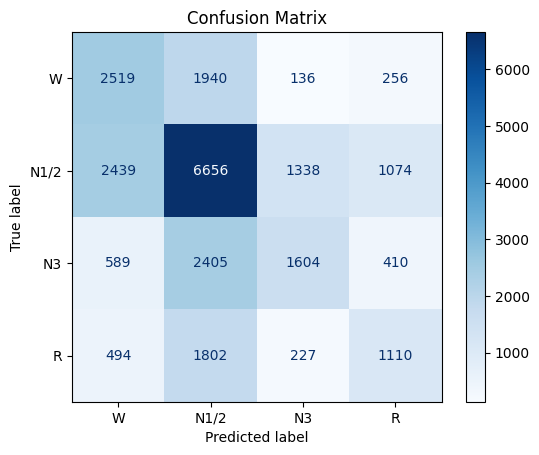


📊 Test (전체) 평가


              precision    recall  f1-score   support

           W       0.51      0.57      0.54      4228
        N1/2       0.55      0.61      0.58     13288
          N3       0.50      0.36      0.42      5803
           R       0.35      0.33      0.34      4280

    accuracy                           0.51     27599
   macro avg       0.48      0.47      0.47     27599
weighted avg       0.50      0.51      0.50     27599



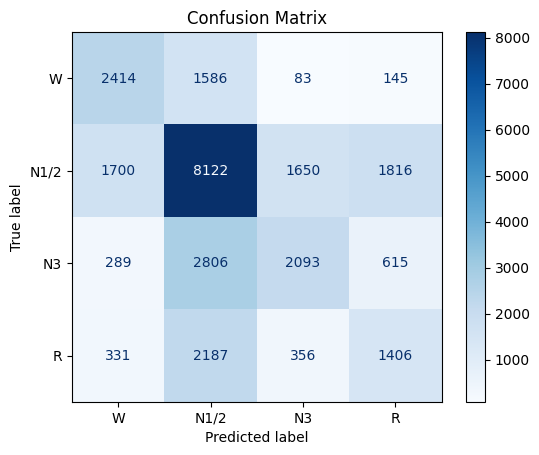

In [11]:
# 9️⃣ 전체 평가
X_val_all, y_val_all = merge_data(val_data)
if len(X_val_all) > 0:
    print("\n📊 Validation (전체) 평가")
    evaluate_model(model, DataLoader(SleepDataset(X_val_all, y_val_all), batch_size=batch_size, shuffle=False))

X_test_all, y_test_all = merge_data(test_data)
if len(X_test_all) > 0:
    print("\n📊 Test (전체) 평가")
    evaluate_model(model, DataLoader(SleepDataset(X_test_all, y_test_all), batch_size=batch_size, shuffle=False))